In [ ]:
import keras
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import pickle

from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization , Activation
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from keras import backend as K
from keras import regularizers
from random import randint
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from keras.layers.normalization import BatchNormalization
from google.colab import drive
from tensorflow.keras.models import model_from_json
from sklearn.metrics import accuracy_score
from keras.optimizers import Adam
drive.mount('/content/drive')
from sklearn.metrics import confusion_matrix 

Choosing good hyperparameters provides two main benefits:

Efficient search across the space of possible hyperparameters; and
Easier management of a large set of experiments for hyperparameter tuning.

In [ ]:
def train_model():
    path =  '/content/drive/My Drive/ATT/'

    # 1-hot encoding
    a = np.array([i for i in range(43)])
    classes = np.zeros((a.size, a.max() + 1))
    classes[np.arange(a.size), a] = 1

    train_array = []
    test_array = []
    dir_array = []

    # let random index and 9th(enumerate begins at 0 so index 8 represents image 9) pgm for test
    for dir in os.listdir(path):
        i1, i2 = 8, randint(0, 7)
        for idx, img in enumerate(sorted(os.listdir(path + dir))):
            image = cv2.imread(path + dir + '/' + img, 0)
            image = cv2.resize(image, (32, 32))
            image = image[:, :, np.newaxis]
            if idx == i1 or idx == i2:
                test_array.append((image, classes[os.listdir(path).index(dir)]))
                continue

            train_array.append((image, classes[os.listdir(path).index(dir)]))
        dir_array.append(dir)

    im_shape = (32, 32, 1)
    output  = len(classes)
    
    model = Sequential()
    
    model.add(Conv2D(64,
                    (3,3),
                    padding="valid",
                    activation="relu",
                    input_shape=im_shape))
    model.add(Conv2D(64,
                    (3,3),
                    padding="valid",
                    activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
              
    model.add(Dropout(0.2))
    
    model.add(Conv2D(128,
                    (3,3),
                    padding="valid",
                    activation="relu"))
    model.add(Conv2D(128,
                    (3,3),
                    padding="valid",
                    activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    
    model.add(Dropout(0.2))
    model.add(Dense(512, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation="relu"))
    model.add(Dense(output))
    model.add(Activation("softmax"))

    model.summary() 
    
    model.compile(optimizer= 'adam', 
                  loss='categorical_crossentropy',
                  metrics = ['accuracy'])

    train_images, train_labels = np.array([t[0] for t in train_array]), np.array([t[1] for t in train_array])
    test_images, test_labels = np.array([t[0] for t in test_array]), np.array([t[1] for t in test_array])

   
    history = model.fit(train_images, train_labels,
                        batch_size=20,
                        epochs=40,
                        verbose=2,
                        validation_data=(test_images, test_labels))
    

    model_json = model.to_json()
    with open("/content/drive/My Drive/SAVEDMODELS/newfacemodel2.json", "w") as json_file:
        json_file.write(model_json)
        print("[INFO] the model is saved into jason file.")
        # serialize weights to HDF5
        model.save_weights('/content/drive/My Drive/SAVEDMODELS/newfaceweights2.h5')
        print("[INFO] Model weights are saved successfully")

   
    print(history.history.keys())
    plt.figure(1, figsize = (15,8))   
    plt.subplot(221)  
    plt.plot(history.history['accuracy'])  
    plt.plot(history.history['val_accuracy'])  
    plt.title('model accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'valid']) 
    plt.subplot(222)  
    plt.plot(history.history['loss'])  
    plt.plot(history.history['val_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'valid']) 
    plt.show()

    return test_images, test_labels, classes, dir_array

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 30, 30, 64)        640       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 10, 10, 128)       147584    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 128)        

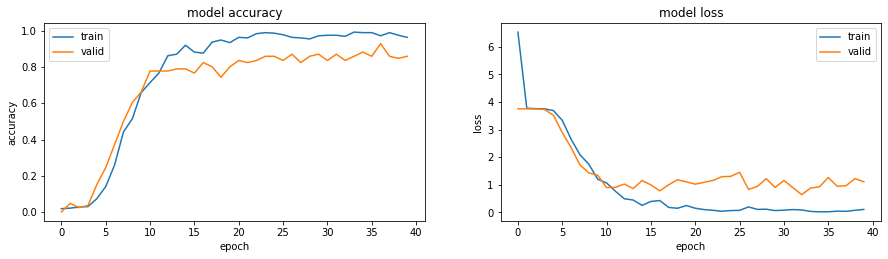

In [ ]:
ti, tl, c, d = train_model()

In [ ]:
 def load_model_and_weights():
    print("[INFO] Loading face model and its weights...")
    # Loading and using saved model steps
    # load json and create model
    js_file = open('/content/drive/My Drive/SAVEDMODELS/newfacemodel2.json', 'r')
    loaded_model_json = js_file.read()
    js_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new loaded model
    loaded_model.load_weights('/content/drive/My Drive/SAVEDMODELS/newfaceweights2.h5')
    print("Loaded face model with its weights from drive")
    return loaded_model

In [ ]:
 loadedmodel = load_model_and_weights()
 loadedmodel.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

[INFO] Loading face model and its weights...
Loaded face model with its weights from drive


In [ ]:
 score = loadedmodel.evaluate(ti, tl, verbose=0)
 print('Test loss:', score[0])
 print('Test accuracy:', score[1])

Test loss: 1.1123974323272705
Test accuracy: 0.8604651093482971


In [ ]:
def evaluate_model(test_images, test_labels, classes, dir_array):
    
    model = loadedmodel

    # evaluate test images added in the orl database
    imageindex = 9

    pathsorin1 = '/content/drive/My Drive/ATT/s1/' + str(imageindex) + '.pgm'
    sorin1 = cv2.imread(pathsorin1, cv2.IMREAD_UNCHANGED)
    sorin1 = cv2.resize(sorin1, (32, 32))
    sorin1 = sorin1[:, :, np.newaxis]

    imageindex = 9

    pathandreea1 = '/content/drive/My Drive/ATT/s6/' + str(imageindex) + '.pgm'
    andreea1 = cv2.imread(pathandreea1, cv2.IMREAD_UNCHANGED)
    andreea1 = cv2.resize(andreea1, (32, 32))
    andreea1 = andreea1[:, :, np.newaxis]

    imageindex = 9

    pathalex1 = '/content/drive/My Drive/ATT/s9/' + str(imageindex) + '.pgm'
    alex1 = cv2.imread(pathalex1, cv2.IMREAD_UNCHANGED)
    alex1 = cv2.resize(alex1, (32, 32))
    alex1 = alex1[:, :, np.newaxis]

    test1 = np.array([sorin1])
    pred1 = model.predict(test1)

    test2 = np.array([andreea1])
    pred2 = model.predict(test2)


    people_test_image = np.array([sorin1, andreea1, alex1])

    [prediction1, prediction2, prediction3] = model.predict(people_test_image)
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

    a = max([(c, cosine_similarity([prediction1], [c])) for c in classes], key=lambda t:t[1])
    b = max([(c, cosine_similarity([prediction2], [c])) for c in classes], key=lambda t:t[1])
    c = max([(c, cosine_similarity([prediction3], [c])) for c in classes], key=lambda t:t[1])

    print(dir_array[list(a[0]).index(1)])
    print(dir_array[list(b[0]).index(1)])
    print(dir_array[list(c[0]).index(1)])




    # FAR calculator
    tresh=[]
    percent=[]
    treshold=0
    while  treshold < 100:
        accepted_reg=0
        for registered_index in pred1:
          counter_reg=0
          array_reg=np.array([0.0])
          max_confidence_reg = array_reg.astype(type('float32', (float,), {}))
          max_confIndex_reg=0
          for j in registered_index:
            if (j > max_confidence_reg):
              max_confidence_reg=j
              max_confIndex_reg=counter_reg
            counter_reg=counter_reg+1
          if(max_confidence_reg > treshold*0.01):
            accepted_reg+=1
        tresh.append(treshold)
        percent.append((80-accepted_reg)/80)
        treshold+=0.01


    tresh_imp=[]
    percent_imp=[]
    treshold_imp=0
    while  treshold_imp <100:
        accepted_imp=0
        for imp_index in pred2:
          counter_imp=0
          array_imp=np.array([0.0])
          max_confidence_imp = array_imp.astype(type('float32', (float,), {}))
          max_confIndex_imp=0
          for j in imp_index:
            if (j > max_confidence_imp):
              max_confidence_imp=j
              max_confIndex_imp=counter_imp
            counter_imp+=1
          if(max_confidence_imp > treshold_imp*0.01):
            accepted_imp+=1
        tresh_imp.append(treshold_imp)
        percent_imp.append((accepted_imp)/80)
        treshold_imp+=0.01


    equal_tresh=[]
    equal_percent=[]
    for i in range(0,len(tresh_imp)):
      if (percent_imp[i] == percent[i]):
        equal_tresh.append(tresh_imp[i])
        equal_percent.append(percent_imp[i])

    #print("Equal Treshold :",equal_tresh)
    plt.plot(tresh,percent)
    plt.plot(tresh_imp,percent_imp)
    plt.plot(equal_tresh,equal_percent)
    plt.title('Error Rate')  
    plt.ylabel('percentage')  
    plt.xlabel('treshold level')  
    plt.legend(['FRR', 'FAR','EER']) 
    plt.show()

    
    


s1
s6
s9


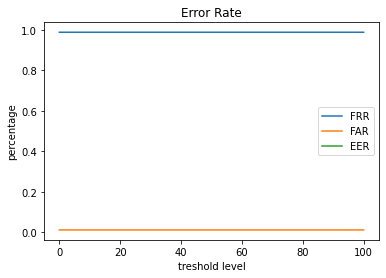

In [ ]:
evaluate_model(ti, tl, c, d)

In [ ]:
a = []
for i in range(100):
        imageindex = 9
        pathandreea1 = '/content/drive/My Drive/ATT/s6/' + str(imageindex) + '.pgm'
        andreea1 = cv2.imread(pathandreea1, cv2.IMREAD_UNCHANGED)
        andreea1 = cv2.resize(andreea1, (32, 32))
        andreea1 = andreea1[:, :, np.newaxis]

        test1 = np.array([andreea1])

        #random_face_pixels = testX_imposter_faces[i]
        #random_face_emb = testX_imposter[i]
        #random_face_class = testy_imposter[i]
        #samples = expand_dims(random_face_emb, axis=0)
        yhat_class = model.predict(test1)
        yhat_prob = model.predict_proba(test1)
        class_index = yhat_class[0]
        class_probability = yhat_prob[0,class_index] * 100
        intp = int((class_probability))
        #print(f'Predicted: {intp} %')
        a.append(intp)

In [ ]:
# far is a list that we will save the False accaptance rate in each threshold 
 # threshold is the list of thresold and it will go from 0% to 100%       
far = []
threshold = []
for i in range(100):
        num = 0

        for x in a:
                if x>i:
                        num+=1
        #print(i,num)
        far.append(num)
        threshold.append(i)

far = np.array(far)
print('FAR: ',far)
print('-----------------------------------------------------------')

In [ ]:
b = []
for i in range(100):
        random_face_pixels = test_X_gen_faces[i]
        random_face_emb = testX_gen[i]
        random_face_class = testy_gen[i]
        face_name = out_encoder.inverse_transform([random_face_class])
        # prediction for the face
        samples = expand_dims(random_face_emb, axis=0)
        yhat_class = model.predict(samples)
        yhat_prob = model.predict_proba(samples)
        # get name
        class_index = yhat_class[0]
        class_probability = yhat_prob[0,class_index] * 100
        predict_threshold = out_encoder.inverse_transform(yhat_class)
        if predict_threshold[0]==face_name[0]:
                intp = int((class_probability))
                #print(f'Predicted: {intp} %')
                b.append(intp)
print(b)

In [ ]:
frr = []
for i in range(100):
        num = 0

        for x in b:
                if x<i:
                        num+=1
        #print(i,num)
        frr.append(num)


frr = np.array(frr)
print('FRR: ',frr)
print('-----------------------------------------------------------')

In [ ]:
# calculate the EER
for i  in range(100):
        a = frr[i]
        b = far[i]
        if a == b:
                EER= a
                print('EER = ',i)

In [ ]:
plt.plot(threshold,frr,'--b',far,'--r')
plt.plot(15,EER,'ro') 

plt.xlabel('threshold')
plt.title('FAR,FRR and EER')
plt.axis([0, 100, 0, 100])
plt.show()

In [ ]:
threshold = np.array(threshold)

In [ ]:
plt.plot(threshold,frr,'--b')
plt.xlabel('threshold')
plt.title('FRR')
plt.axis([0, 100, 0, 100])
plt.show()

In [ ]:
plt.plot(threshold,far,'--r')
plt.xlabel('threshold')
plt.title('FAR')

plt.axis([5, 20, 0, 100])
plt.show()

In [ ]:
imgs = '/content/drive/My Drive/ATT/s2'

In [ ]:
img1 = np.array(imgs[0])

In [ ]:
img1 = cv2.imread(img1)
plt.imshow(img1)

SystemError: ignored